In [2]:
import os
import cv2
import keras
import math
import random
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from skimage import exposure

Using TensorFlow backend.


In [3]:
# Memory error, so to feed model in batches
batch_size = 10
train_dir = '../few_images/Gray'
validation = '../few_images/validation'

In [4]:
#custom image augmentation function
def custom_preprocessing(image):
    state = random.randint(0,2)
    if state == 0:
        processed_img = exposure.equalize_adapthist((image*1.0/255), clip_limit=0.02)
    elif state == 1:
        processed_img = exposure.equalize_hist(image)
    elif state == 2:
        p2, p98 = np.percentile(image, (2,98))
        processed_img = exposure.rescale_intensity(image)
    return processed_img

image_gen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=custom_preprocessing)

In [32]:
# LAB range L (0,100); ab (-128,127)
# function to split training set X train, y train and produce augmented images       
def image_a_b_gen(batch_size):
    for i in image_gen.flow_from_directory(validation, batch_size=batch_size, class_mode=None, shuffle=False):
        X_train = gray2rgb(rgb2gray(i))
        y_train = i
        yield ([X_train, y_train])

In [23]:
for i in image_gen.flow_from_directory(validation, batch_size=batch_size, class_mode=None, shuffle=False):
    gray_batch = rgb2gray(i)
    X_train = gray_batch.reshape(gray_batch.shape+(1,))
    y_train = i
    break

Found 200 images belonging to 1 classes.


In [31]:
y_train.shape

(10, 256, 256, 3)

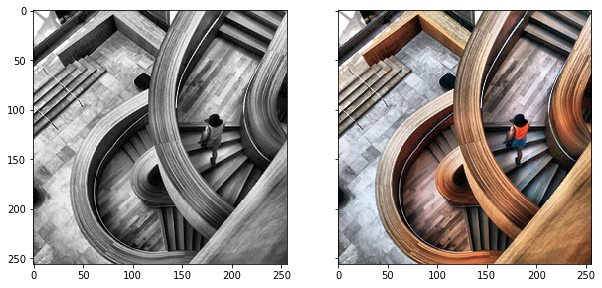

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(gray2rgb(gray_batch)[3],cmap=plt.cm.gray)
ax[1].imshow(y_train[3])

In [33]:
class DSSIMObjective:
    def __init__(self, k1=0.01, k2=0.03, max_value=1.0):
        self.__name__ = 'DSSIMObjective'
        self.k1 = k1
        self.k2 = k2
        self.max_value = max_value
        self.backend = K.backend()

    def __int_shape(self, x):
        return K.int_shape(x) if self.backend == 'tensorflow' else K.shape(x)

    def __call__(self, y_true, y_pred):
        ch = K.shape(y_pred)[-1]

        def _fspecial_gauss(size, sigma):
            #Function to mimic the 'fspecial' gaussian MATLAB function.
            coords = np.arange(0, size, dtype=K.floatx())
            coords -= (size - 1 ) / 2.0
            g = coords**2
            g *= ( -0.5 / (sigma**2) )
            g = np.reshape (g, (1,-1)) + np.reshape(g, (-1,1) )
            g = K.constant ( np.reshape (g, (1,-1)) )
            g = K.softmax(g)
            g = K.reshape (g, (size, size, 1, 1)) 
            g = K.tile (g, (1,1,ch,1))
            return g
                  
        kernel = _fspecial_gauss(11,1.5)

        def reducer(x):
            return K.depthwise_conv2d(x, kernel, strides=(1, 1), padding='valid')

        c1 = (self.k1 * self.max_value) ** 2
        c2 = (self.k2 * self.max_value) ** 2
        
        mean0 = reducer(y_true)
        mean1 = reducer(y_pred)
        num0 = mean0 * mean1 * 2.0
        den0 = K.square(mean0) + K.square(mean1)
        luminance = (num0 + c1) / (den0 + c1)
        
        num1 = reducer(y_true * y_pred) * 2.0
        den1 = reducer(K.square(y_true) + K.square(y_pred))
        c2 *= 1.0 #compensation factor
        cs = (num1 - num0 + c2) / (den1 - den0 + c2)

        ssim_val = K.mean(luminance * cs, axis=(-3, -2) )
        return K.mean( (1.0 - ssim_val ) / 2.0 )

In [34]:
ssim_loss = DSSIMObjective()

In [40]:
model = Sequential()

#Downsampling batch
model.add(InputLayer(input_shape=(256, 256, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))                     
model.add(BatchNormalization())                                               #(bs,256, 256,64)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))            
model.add(BatchNormalization())                                               #(bs,128,128,64)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))                     
model.add(BatchNormalization())                                               #(bs,128,128,128)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))          
model.add(BatchNormalization())                                               #(bs,64,64,128)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))                     
model.add(BatchNormalization())                                               #(bs,64,64,256)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))            
model.add(BatchNormalization())                                               #(bs,32,32,256)
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))                     
model.add(BatchNormalization())                                               #(bs,32,32,512)

#Upsampling batch
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))        
model.add(BatchNormalization())
model.add(Dropout(0.5))                                                       #(bs,32,32,512)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))     
model.add(BatchNormalization())
model.add(Dropout(0.5))                                                       #(bs,32,32,256)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))        
model.add(BatchNormalization())
model.add(Dropout(0.5))                                                       #(bs,32,32,128)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))        
model.add(BatchNormalization()) 
model.add(UpSampling2D((2, 2)))                                               #(bs,64,64,64)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))        
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))                                               #(bs,128,128,32)
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))         
model.add(UpSampling2D((2, 2)))                                               #(bs,256,256,2)

# Finish model
model.compile(optimizer='adam', loss=ssim_loss ,metrics=['mse','mean_absolute_error'])

In [41]:
# Train model
model.fit_generator(image_a_b_gen(batch_size), steps_per_epoch=10, epochs=100)

Epoch 1/100
Found 200 images belonging to 1 classes.
10/10 [==============================] - 126s 13s/step - loss: 0.4874 - mean_squared_error: 1.1808 - mean_absolute_error: 0.5983
Epoch 2/100
10/10 [==============================] - 124s 12s/step - loss: 0.4241 - mean_squared_error: 0.3095 - mean_absolute_error: 0.3051
Epoch 3/100
10/10 [==============================] - 125s 12s/step - loss: 0.3398 - mean_squared_error: 0.0628 - mean_absolute_error: 0.1813
Epoch 4/100
10/10 [==============================] - 125s 12s/step - loss: 0.3168 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1601
Epoch 5/100
10/10 [==============================] - 124s 12s/step - loss: 0.2915 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1425
Epoch 6/100
10/10 [==============================] - 125s 12s/step - loss: 0.2930 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1539
Epoch 7/100
10/10 [==============================] - 125s 12s/step - loss: 0.2795 - mean_squared_error: 0.0362 - 

FileNotFoundError: [Errno 2] No such file or directory: '../few_images/validation\\validation\\4wwe7b.jpg'

In [174]:
model.save('C:/Users/n3rDx/Desktop/Homework Upload/Capstone/5th_expt_lab_tanh_100_2categories.hdf5')

In [188]:
# Load black and white images
test = []
for filename in os.listdir('../few_images/Test'):
        test.append(img_to_array(load_img('C:/Users/n3rDx/Desktop/Homework Upload/Capstone/few_images/test/'+filename)))
lab_test = (rgb2lab(test)[:,:,:,0])*1.0/10000.0
lab_test = lab_test.reshape(lab_test.shape+(1,))

In [190]:
# Test model
output = model.predict(lab_test)

In [189]:
lab_test.max()

0.9341571978788683

In [200]:
# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = lab_test[i][:,:,0]*100
    cur[:,:,1:] = output[i]*100
    #result = np.concatenate((lab_test[i], output[i]), axis=2)
    picture = lab2rgb(cur).astype('uint8')
    imsave("C:/Users/n3rDx/Desktop/Homework Upload/Capstone/results/"+str(i)+".jpg", picture)

C:\Users\n3rDx\Anaconda3\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 682 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\n3rDx\Anaconda3\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 2309 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\n3rDx\Anaconda3\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 305 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\n3rDx\Anaconda3\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\n3rDx\Anaconda3\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixel

0.9979993

In [ ]:

# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean square error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Structural Similarity Index')
plt.ylabel('SSIM')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()